In [93]:
library(tidyverse)
options(repr.plot.width=10, repr.plot.height=6)
theme_set(theme_classic())

pwr_plot <- function(mu, n) {
    sd <- 1 / sqrt(n)
    curve(dnorm(x, mean=0, sd=sd), from=-3, to=3 + mu, col="blue")
    curve(dnorm(x, mean=mu, sd=sd), add=T, col="red")
    legend("topright", 
       legend = c("H0", "H1"),
       col = c("blue", "red"), 
       lwd = 2)
    abline(v=-2 * sd, lty=2)
    abline(v=2 * sd, lty=2)

}

library(future.apply)
plan(multisession, workers = 24)

# STATS 504
## Week 10: Power, effect size, reproducibility

### Figuring out the standard effect size

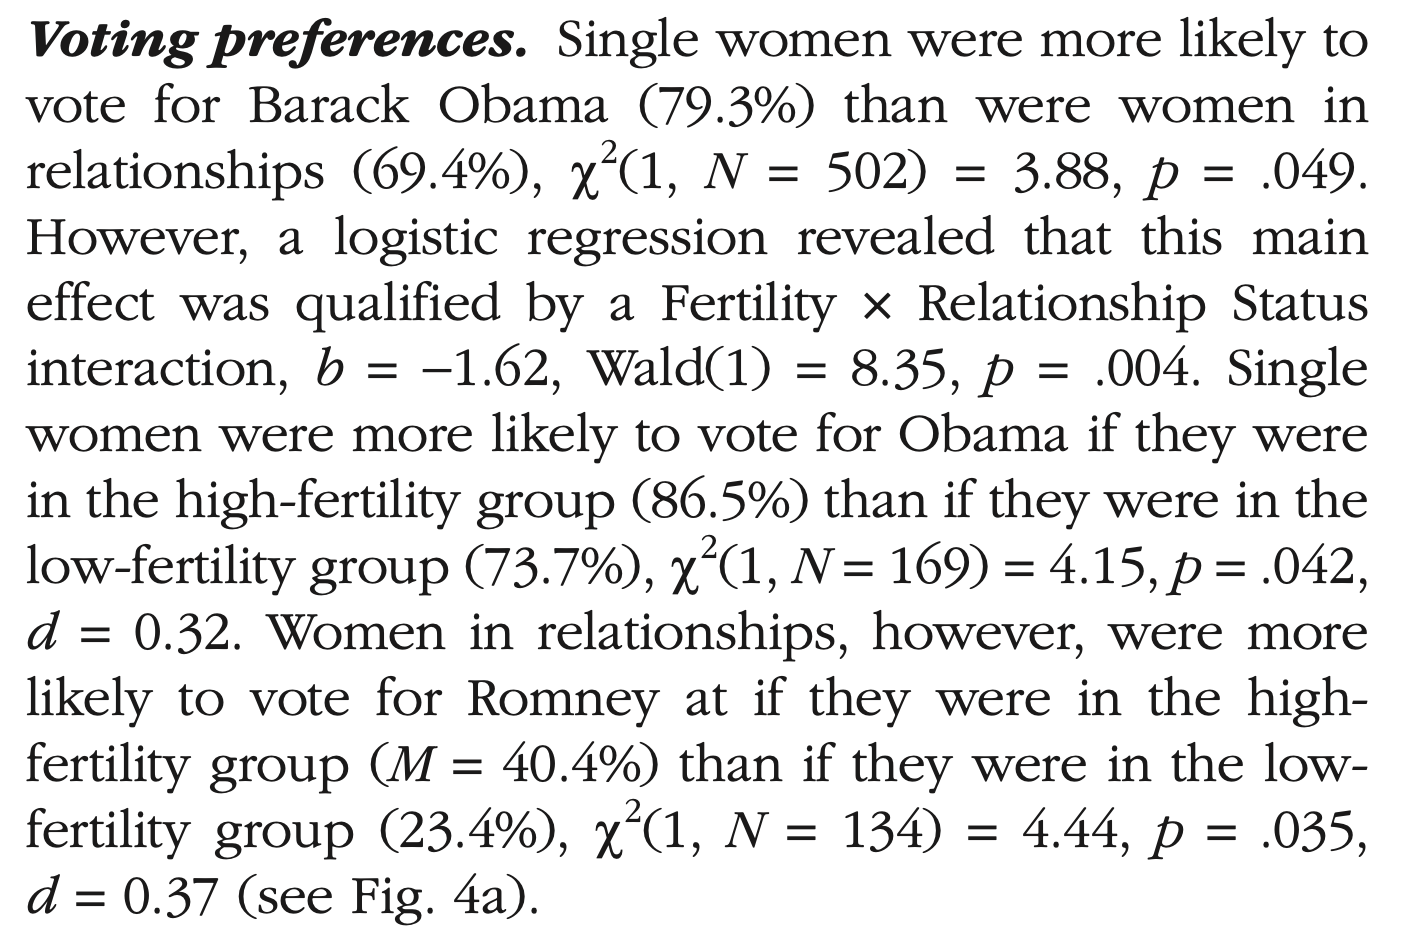

### Exercise
Suppose the true effect size is 2%, with experimental standard error of 8%.

- What is the power?
- What is the probability of a type S error?
- What is the expected exaggeration ratio?

In [ ]:
# solution

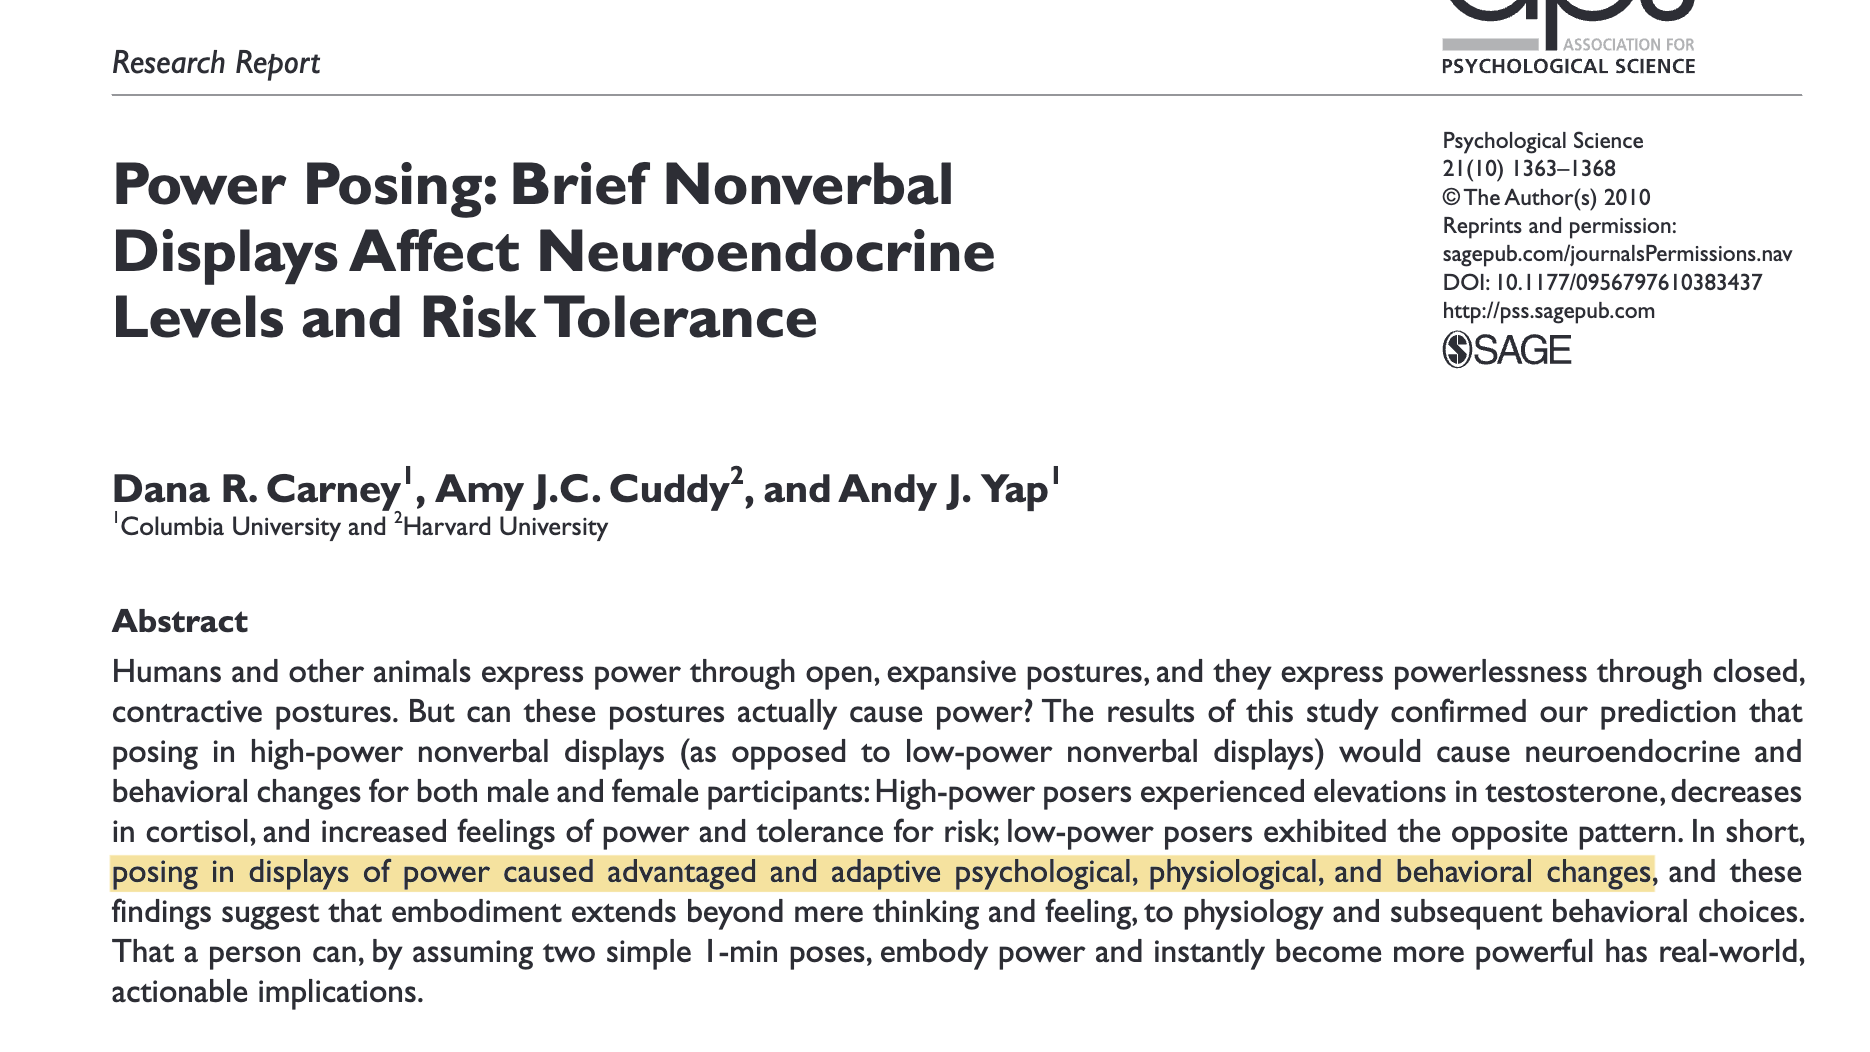

### The $p$-curve

- Suppose we run a bunch of studies and report all the findings honestly. 
- **Q**: What is the distribution of significant $p$-values that we would observe?
- i.e. $\mathbb{P}(p\mid p<0.05)$

- **A**: Uniform
- When the null hypothesis is true, there is a 5% chance of observing a p < .05, a 4% chance of observing a p < .04, a 3% chance of observing a p < .03, and so on. 
- This means there is a 1% chance of observing a p < .01, a 1% chance of observing a p value between .01 and .02, a 1% chance of observing a p value between .02 and .03, and so on.

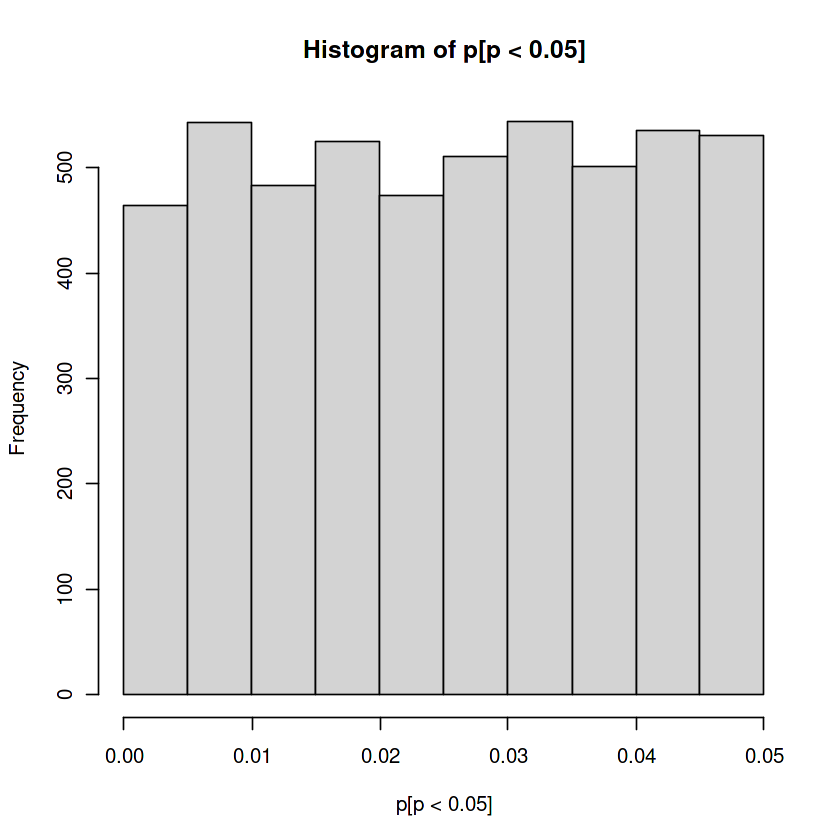

In [57]:
d = 0.0   # standardized difference in means

experiment <- function() {
    z1 = rnorm(mean=0, n=20)
    z2 = rnorm(mean=d, n=20)
    t.test(z1, z2)$p.value
}

p <- replicate(100000, experiment())
hist(p[p<0.05])

In [94]:
d = 0.0   # standardized difference in means

experiment <- function() {
    z1 = rnorm(mean=0, n=40)
    z2 = rnorm(mean=d, n=40)
    pvs <- map_dbl(seq(20, 40, 5), \(n) t.test(head(z1, n), head(z2, n))$p.value)
    r <- pvs[pvs < 0.05][1]
    if (is.na(r))
        r <- pvs[5]
    r
}

pvs <- future_replicate(100000, experiment())

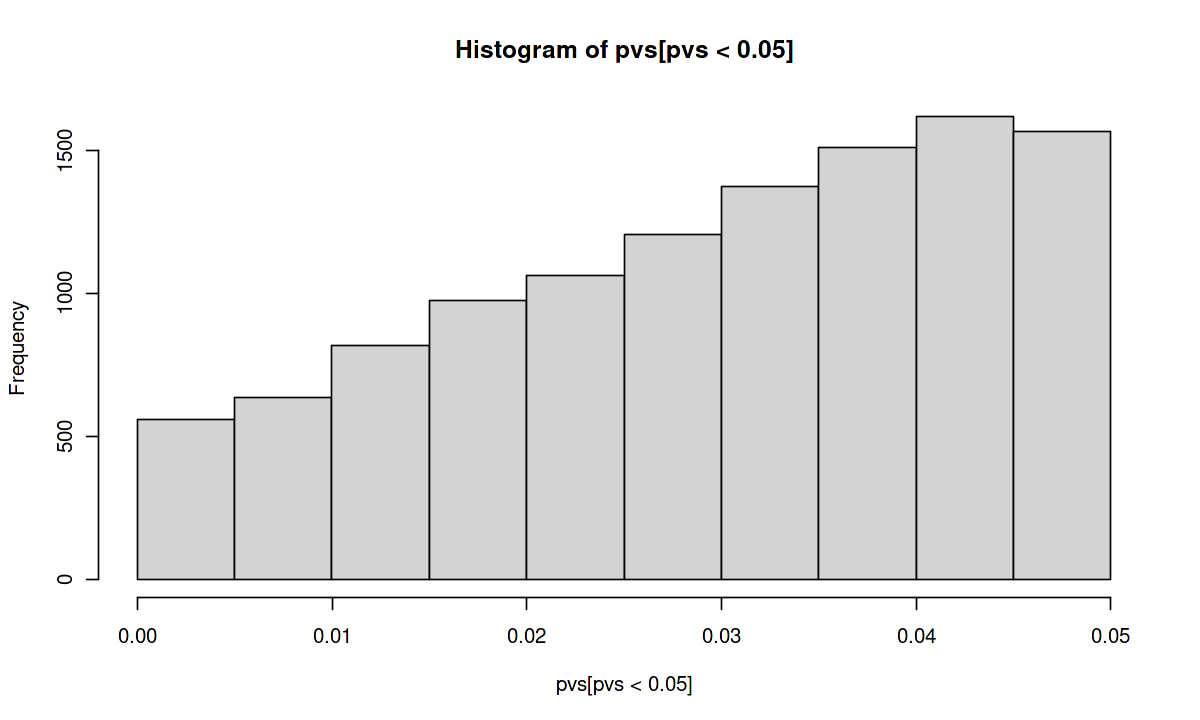

In [97]:
hist(pvs[pvs < 0.05]) 

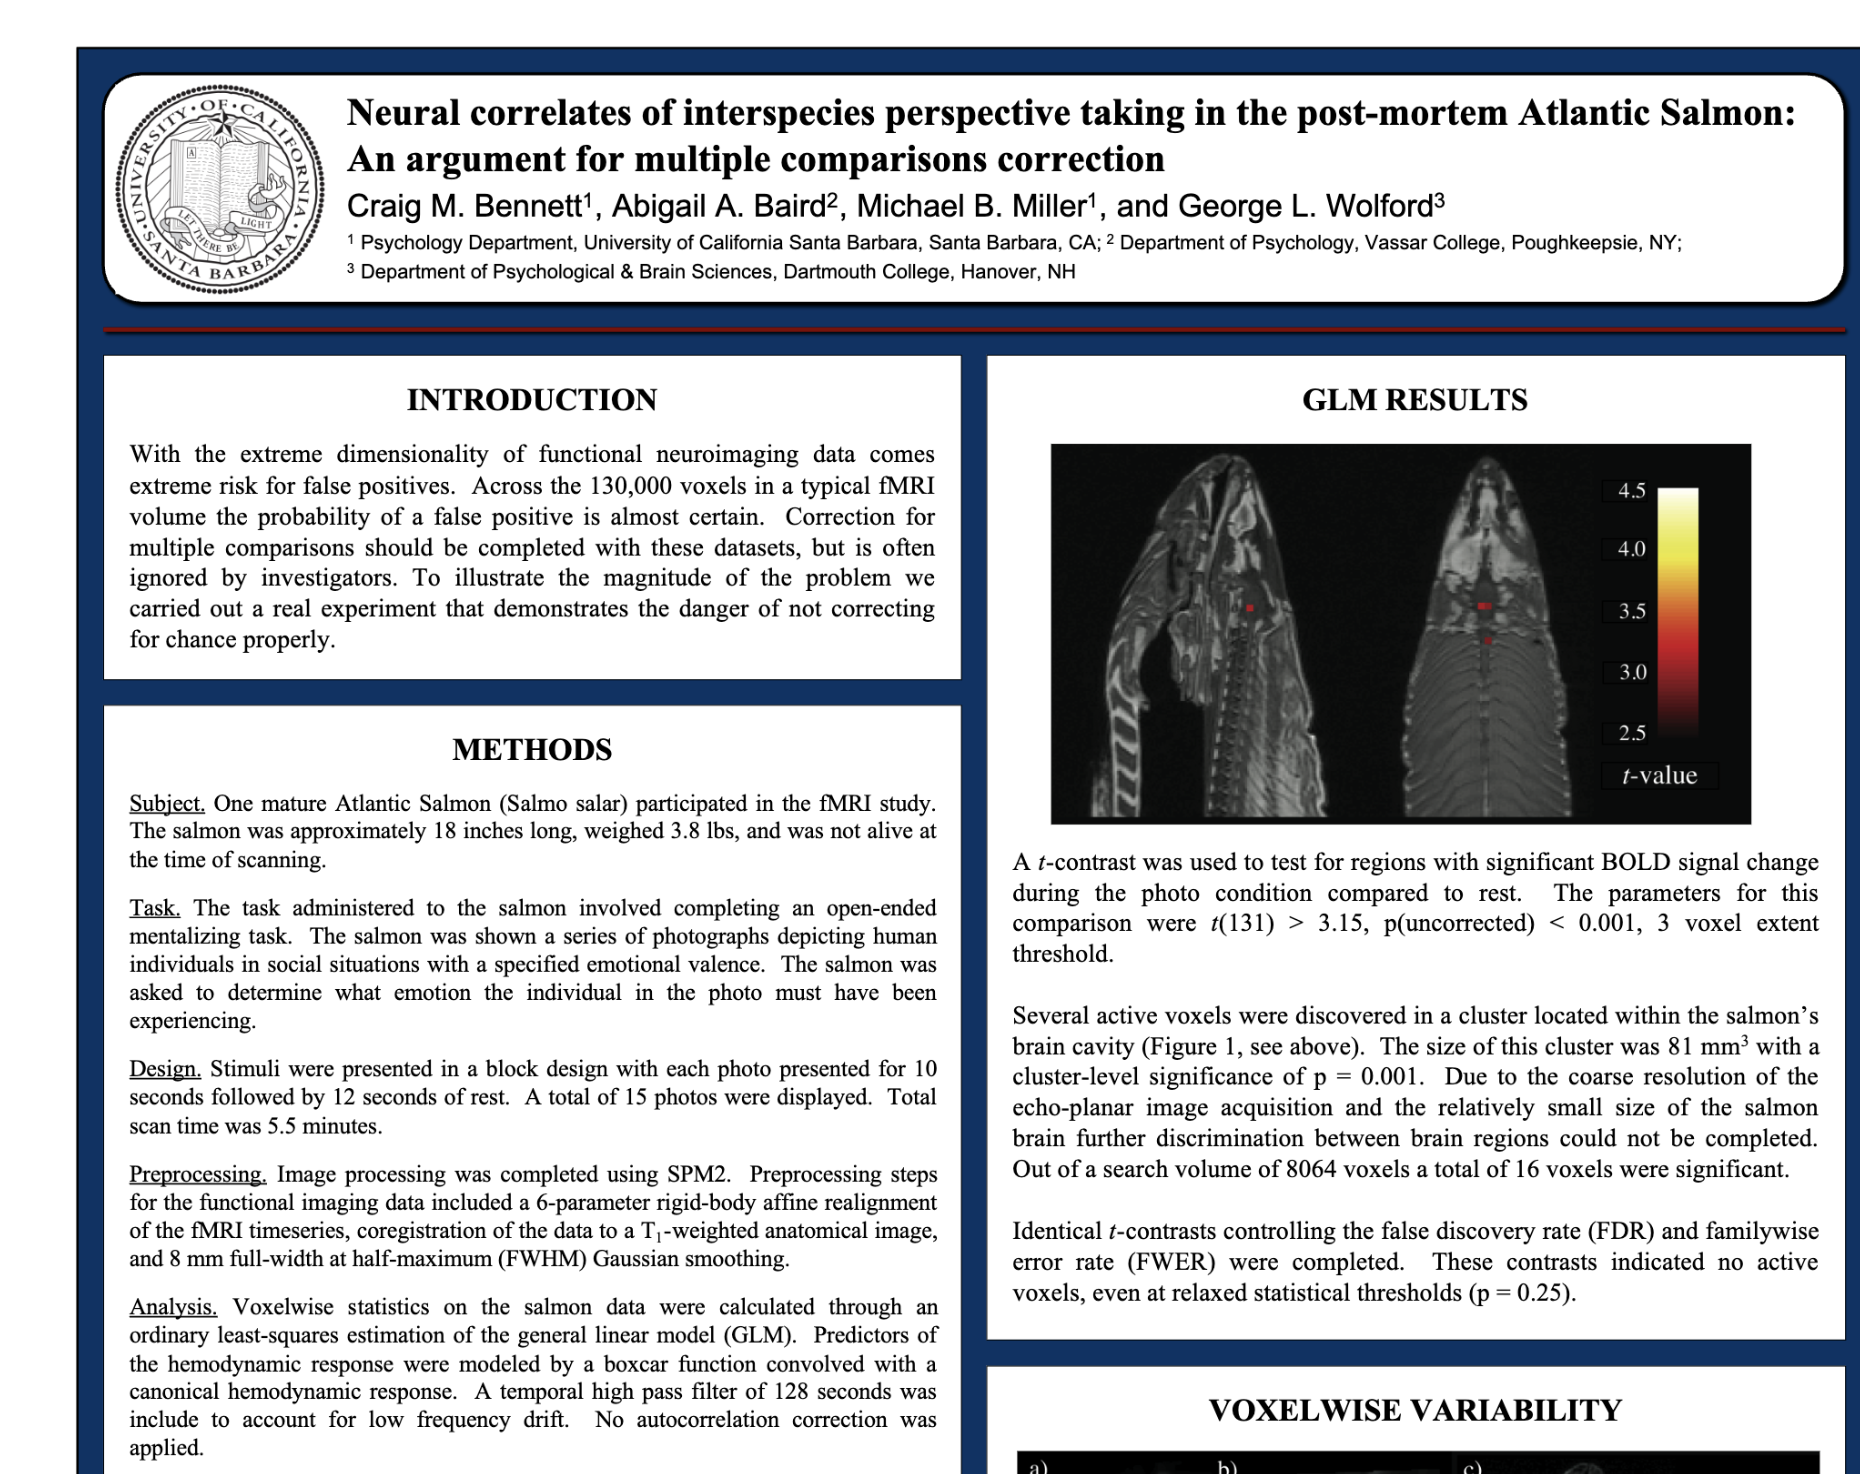

## Are female hurricanes more dangerous than male hurricanes?

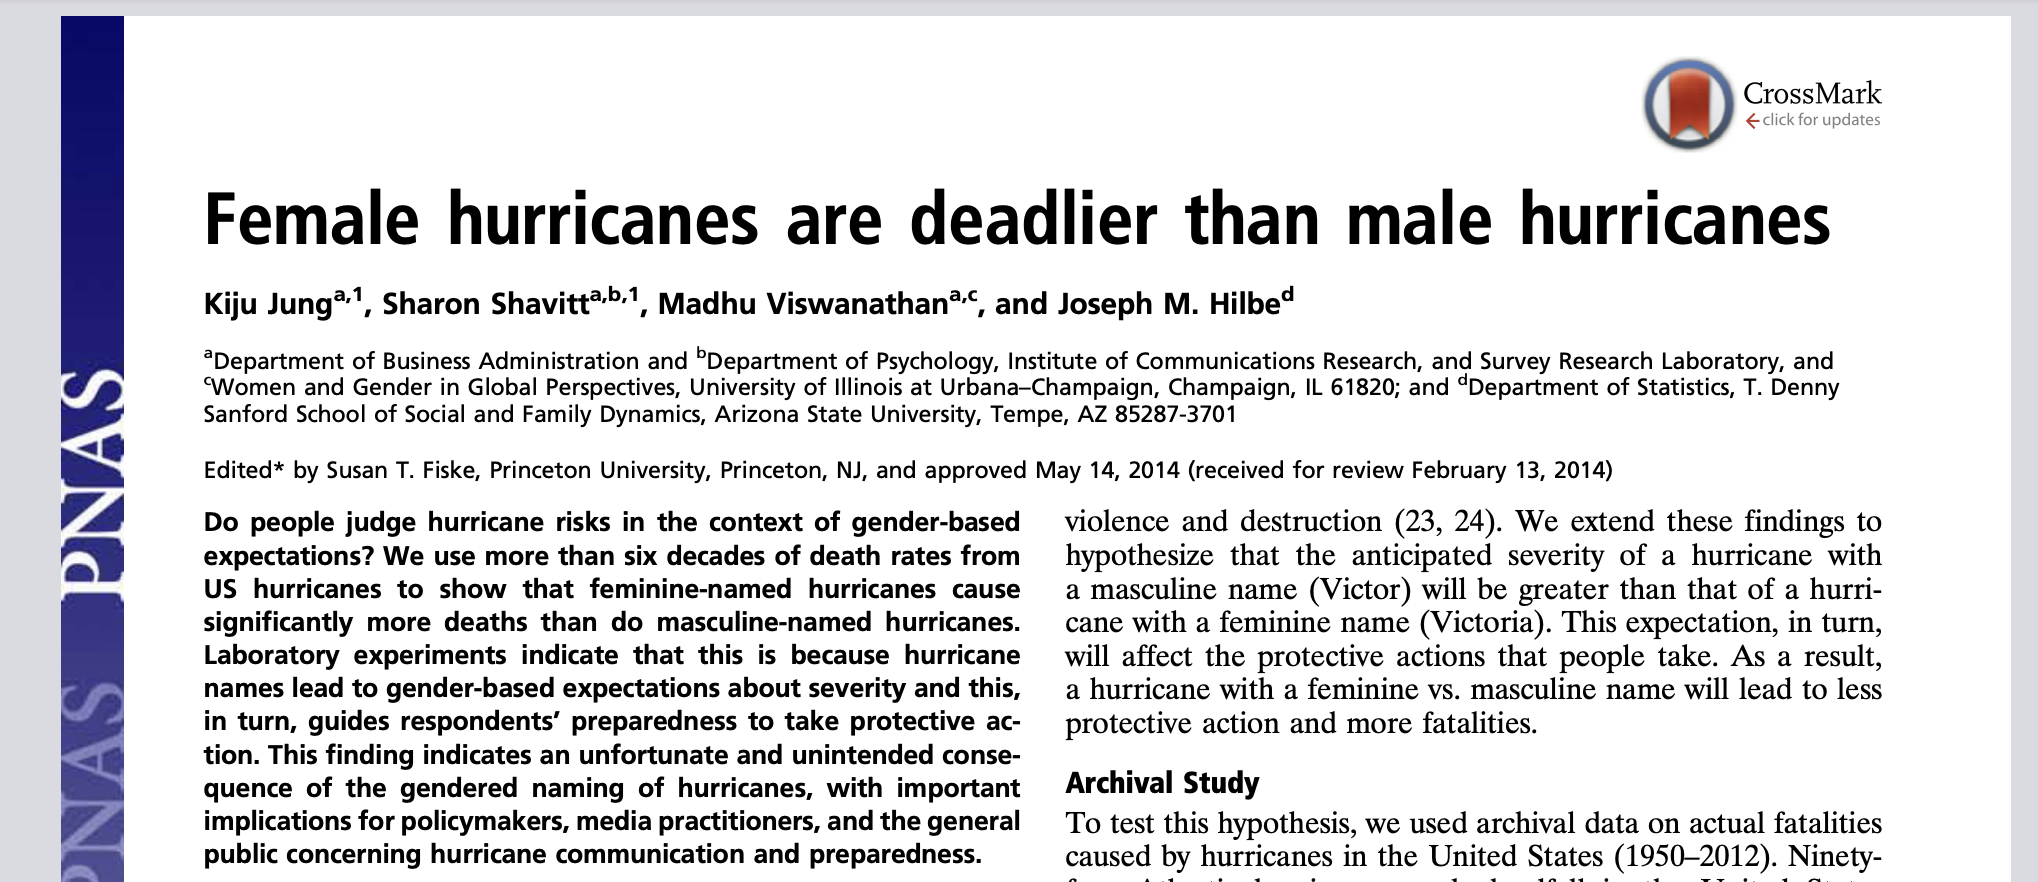

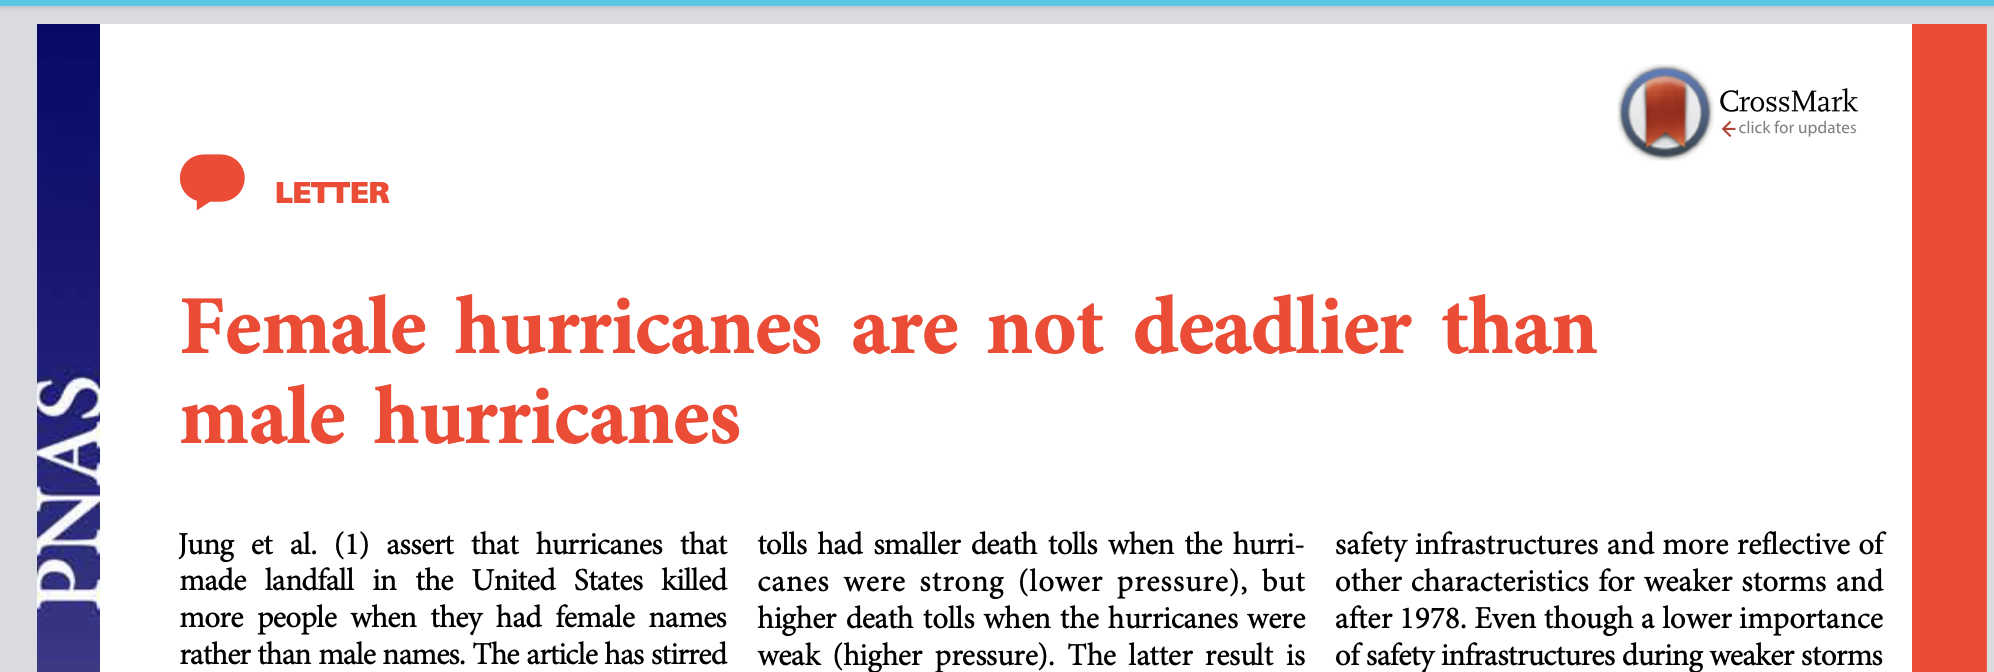

> The results of their archival study are a
function of the selective inclusion of regressors.
Using the same data, methodology, and
variables,  Using the same data, methodology, and
variables, I show in Table 1 that their results
are not robust to the inclusion of the one
two-way interaction they omitted from their
analysis. 

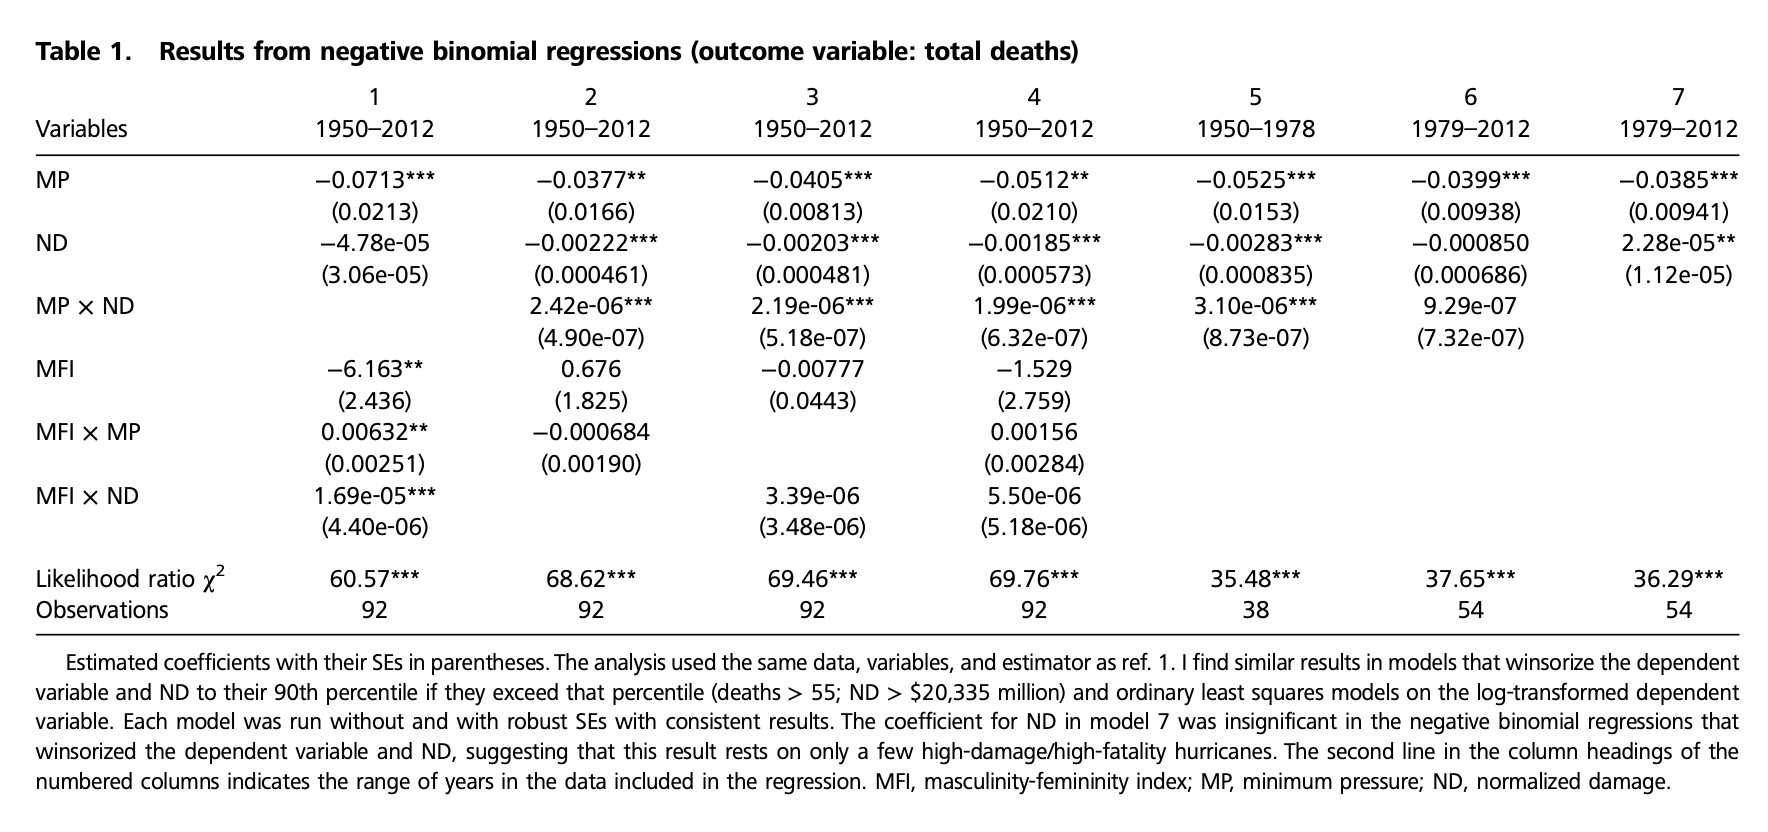

In [99]:
# hur.data <- "https://www.pnas.org/action/downloadSupplement?doi=10.1073%2Fpnas.1402786111&file=pnas.1402786111.sd01.xlsx"
# download.file(hur.data, "pnas.1402786111.sd01.xlsx")
# hurricane <- readxl::read_excel('pnas.1402786111.sd01.xlsx')
# write_csv(hurricane, "hurricane.csv")
hurricane <- read_csv("https://raw.githubusercontent.com/terhorst/stats504/main/lectures/week10/hurricane.csv")

ERROR: Error in open.connection(structure(29L, class = c("curl", "connection": HTTP error 404.


In [78]:
hurricane


Year,Name,MasFem,MinPressure_before,Minpressure_Updated 2014,Gender_MF,Category,alldeaths,NDAM,Elapsed Yrs,Source,ZMasFem,ZMinPressure_A,ZNDAM
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1950,Easy,6.777778,958,960,1,3,2,1590,63,MWR,-0.0009354963,-0.3563582,-0.43913287
1950,King,1.388889,955,955,0,3,4,5350,63,MWR,-1.6707583545,-0.5112478,-0.14842815
1952,Able,3.833333,985,985,0,1,3,150,61,MWR,-0.9133130877,1.0376478,-0.55046659
1953,Barbara,9.833333,987,987,1,1,1,58,60,MWR,0.9458710873,1.1409075,-0.55757958
1953,Florence,8.333333,985,985,1,1,0,15,60,MWR,0.4810750435,1.0376478,-0.56090413
1954,Carol,8.111111,960,960,1,3,60,19321,59,MWR,0.4122164392,-0.2530985,0.93174089
1954,Edna,8.555556,954,954,1,3,20,3230,59,MWR,0.5499339577,-0.5628776,-0.31233613
1954,Hazel,9.444444,938,938,1,4,20,24260,59,MWR,0.8253683748,-1.3889553,1.31360009
1955,Connie,8.500000,962,962,1,3,0,2030,58,MWR,0.5327191517,-0.1498388,-0.40511423


In [79]:
hurricane_data <- hurricane %>%
    # rename some variables
    rename(
        year = Year,
        name = Name,
        dam = NDAM,
        death = alldeaths,
        female = Gender_MF,
        masfem = MasFem,
        category = Category,
        pressure = `Minpressure_Updated 2014`,
    ) %>%
    # create new variables
    # which are relevant later on
    mutate(
        post = ifelse(year>1979, 1, 0),
        zcat = as.numeric(scale(category)),
        zpressure = -scale(pressure),
    )

### Reproducing the main result

In [80]:
df.filtered = hurricane_data %>% 
  filter(name != "Katrina" & name != "Audrey")

In [7]:
df.filtered %>% summarize(across(c(masfem, death, pressure, category, dam), list(mean=mean, sd=sd)))

masfem_mean,masfem_sd,death_mean,death_sd,pressure_mean,pressure_sd,category_mean,category_sd,dam_mean,dam_sd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6.780797,3.227222,20.65217,40.90419,964.913,19.06533,2.086957,1.055099,7269.783,12934.09


In [83]:
library(MASS)

fit = MASS::glm.nb(
  death ~ masfem * dam + masfem * pressure,
  data = df.filtered,
)

summary(fit)


Call:
MASS::glm.nb(formula = death ~ masfem * dam + masfem * pressure, 
    data = df.filtered, init.theta = 0.7867893292, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4961  -1.0440  -0.4778   0.2650   2.6012  

Coefficients:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)      6.994e+01  1.945e+01   3.596 0.000323 ***
masfem          -5.970e+00  2.455e+00  -2.432 0.014999 *  
dam             -3.820e-05  2.852e-05  -1.339 0.180442    
pressure        -6.987e-02  2.000e-02  -3.493 0.000478 ***
masfem:dam       1.588e-05  3.636e-06   4.368 1.25e-05 ***
masfem:pressure  6.108e-03  2.527e-03   2.417 0.015643 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(0.7868) family taken to be 1)

    Null deviance: 180.03  on 91  degrees of freedom
Residual deviance: 102.90  on 86  degrees of freedom
AIC: 660.74

Number of Fisher Scoring iterations: 1


              Theta

In [9]:
library(mgcv)

fit = gam(
  death ~ masfem * dam + masfem * pressure,
  data = df.filtered,
  family = "nb"
)

broom::tidy(fit, TRUE)

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.



term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),7.014482e+01,2.002977e+01,3.502028,4.617313e-04
masfem,-5.986416e+00,2.528981e+00,-2.367126,1.792683e-02
dam,-3.845306e-05,2.945549e-05,-1.305463,1.917351e-01
pressure,-7.008065e-02,2.060045e-02,-3.401899,6.691936e-04
masfem:dam,1.593219e-05,3.755669e-06,4.242169,2.213695e-05
masfem:pressure,6.123656e-03,2.603217e-03,2.352342,1.865563e-02


### What decisions did we make when fitting this model?
- Filtering: exclude female hurricanes that caused a lot of deaths.
- Choice of regression model
- Specification of regression model
- How is everything measured?

In [10]:
library(mgcv)
fit = mgcv::gam(
  death ~ pressure * masfem + pressure * dam,
  data = df.filtered,
)

broom::tidy(fit)

term
<chr>


In [11]:
fit = glm(
  death ~ pressure * masfem + pressure * dam,
  data = df.filtered,
  family = "poisson"
)

broom::tidy(fit)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5.608494e+01,4.588775e+00,12.222204,2.365829e-34
pressure,-5.633584e-02,4.823911e-03,-11.678458,1.642479e-31
masfem,-1.496886e+00,4.899877e-01,-3.054947,2.251002e-03
dam,-1.568298e-03,9.384560e-05,-16.711473,1.081310e-62
pressure:masfem,1.632394e-03,5.156723e-04,3.165564,1.547827e-03
pressure:dam,1.693970e-06,9.960861e-08,17.006262,7.379859e-65


## A multiverse analysis
The `multiverse` package lets us systematically keep track of all the different decisions we made during the analysis.

In [50]:
library(multiverse)
M <- multiverse()
M

Multiverse

  Multiverse consists of 1 different analyses

   Parameters: 
   No parameters have been defined yet


   Conditions: 
     No conditions have been defined yet

In [51]:
inside(M, df <- hurricane_data)

In [52]:
inside(M, {
    df.filtered <- df %>% 
        filter(branch(death_outliers,
                     "no_exclusion" ~ TRUE,
                     "most_extreme" ~ name != "Katrina",
                      "two_most_extreme" ~ (name != "Katrina") & (name != "Audrey")
                     ))
})
M

Multiverse

  Multiverse consists of 3 different analyses

   Parameters: 
     Parameter name: death_outliers 
        options: no_exclusion most_extreme two_most_extreme 

   Conditions: 
     No conditions have been defined yet

In [53]:
parameters(M)

$death_outliers
$death_outliers[[1]]
[1] "no_exclusion"

$death_outliers[[2]]
[1] "most_extreme"

$death_outliers[[3]]
[1] "two_most_extreme"

In [54]:
expand(M)

.universe,death_outliers,.parameter_assignment,.code,.results,.errors
<int>,<chr>,<list>,<list>,<list>,<list>
1,no_exclusion,no_exclusion,"{, df <- hurricane_data, }, {, df.filtered <- df %>% filter(TRUE), }",<environment: 0x5609a14aac28>,"NA, NA"
2,most_extreme,most_extreme,"{, df <- hurricane_data, }, {, df.filtered <- df %>% filter(name != ""Katrina""), }",<environment: 0x5609a14983d8>,"NA, NA"
3,two_most_extreme,two_most_extreme,"{, df <- hurricane_data, }, {, df.filtered <- df %>% filter((name != ""Katrina"") & (name != , ""Audrey"")), }",<environment: 0x5609a1487fa0>,"NA, NA"


In [55]:
code(M)

$`1`
{
    df <- hurricane_data
}

$`2`
{
    df.filtered <- df %>% filter(branch(death_outliers, "no_exclusion" ~ 
        TRUE, "most_extreme" ~ name != "Katrina", "two_most_extreme" ~ 
        (name != "Katrina") & (name != "Audrey")))
}


In [56]:
inside(M, {
    fit_fun <- branch(family, 
                      "gaussian" ~ glm,
                      "poisson" ~ glm,
                      "nb" ~ mgcv::gam
                     )
    fam <- branch(family,
        "gaussian" ~ "gaussian",
        "poisson" ~ "poisson",
        "nb" ~ "nb"
    )
    df.filtered$outcome <- branch(family,
        "gaussian" ~ log1p(df.filtered$death),
        "poisson" ~ df.filtered$death,
        "nb" ~ df.filtered$death
    )
    fit <- fit_fun(outcome ~ branch(formula,
        "marginal" ~ masfem + pressure + dam,
        "2int1" ~ pressure * masfem + pressure * dam,
        "3int" ~ pressure * masfem * dam
        ),
        family = fam, data = df.filtered)
})

In [60]:
M

Multiverse

  Multiverse consists of 27 different analyses

   Parameters: 
     Parameter name: death_outliers 
        options: no_exclusion most_extreme two_most_extreme 
     Parameter name: family 
        options: gaussian poisson nb 
     Parameter name: formula 
        options: marginal 2int1 3int 

   Conditions: 
     No conditions have been defined yet

In [61]:
inside(M, {
    sf <- summary(fit)
    effect <- branch(family,
        "gaussian" ~ coefficients(sf),
        "poisson" ~ coefficients(sf),
        "nb" ~ sf$p.table
    )["masfem", 4]
})

In [62]:
execute_multiverse(M)
multiverse::expand(M) %>% extract_variables(effect)

.universe,death_outliers,family,formula,.parameter_assignment,.code,.results,.errors,effect
<int>,<chr>,<chr>,<chr>,<list>,<list>,<list>,<list>,<dbl>
1,no_exclusion,gaussian,marginal,"no_exclusion, gaussian , marginal","{, df <- hurricane_data, }, {, df.filtered <- df %>% filter(TRUE), }, {, fit_fun <- glm, fam <- ""gaussian"", df.filtered$outcome <- log1p(df.filtered$death), fit <- fit_fun(outcome ~ masfem + pressure + dam, family = fam, , data = df.filtered), }, {, sf <- summary(fit), effect <- coefficients(sf)[""masfem"", 4], }, {, sf <- summary(fit), effect <- coefficients(sf)[""masfem"", 4], }",<environment: 0x5609a971edb0>,"NA, NA, NA, NA, NA",6.991712e-01
2,no_exclusion,gaussian,2int1,"no_exclusion, gaussian , 2int1","{, df <- hurricane_data, }, {, df.filtered <- df %>% filter(TRUE), }, {, fit_fun <- glm, fam <- ""gaussian"", df.filtered$outcome <- log1p(df.filtered$death), fit <- fit_fun(outcome ~ pressure * masfem + pressure * dam, , family = fam, data = df.filtered), }, {, sf <- summary(fit), effect <- coefficients(sf)[""masfem"", 4], }, {, sf <- summary(fit), effect <- coefficients(sf)[""masfem"", 4], }",<environment: 0x5609a6a07518>,"NA, NA, NA, NA, NA",4.973535e-01
3,no_exclusion,gaussian,3int,"no_exclusion, gaussian , 3int","{, df <- hurricane_data, }, {, df.filtered <- df %>% filter(TRUE), }, {, fit_fun <- glm, fam <- ""gaussian"", df.filtered$outcome <- log1p(df.filtered$death), fit <- fit_fun(outcome ~ pressure * masfem * dam, family = fam, , data = df.filtered), }, {, sf <- summary(fit), effect <- coefficients(sf)[""masfem"", 4], }, {, sf <- summary(fit), effect <- coefficients(sf)[""masfem"", 4], }",<environment: 0x5609a473e5f8>,"NA, NA, NA, NA, NA",5.896454e-01
4,no_exclusion,poisson,marginal,"no_exclusion, poisson , marginal","{, df <- hurricane_data, }, {, df.filtered <- df %>% filter(TRUE), }, {, fit_fun <- glm, fam <- ""poisson"", df.filtered$outcome <- df.filtered$death, fit <- fit_fun(outcome ~ masfem + pressure + dam, family = fam, , data = df.filtered), }, {, sf <- summary(fit), effect <- coefficients(sf)[""masfem"", 4], }, {, sf <- summary(fit), effect <- coefficients(sf)[""masfem"", 4], }",<environment: 0x5609a30646e0>,"NA, NA, NA, NA, NA",3.660634e-25
5,no_exclusion,poisson,2int1,"no_exclusion, poisson , 2int1","{, df <- hurricane_data, }, {, df.filtered <- df %>% filter(TRUE), }, {, fit_fun <- glm, fam <- ""poisson"", df.filtered$outcome <- df.filtered$death, fit <- fit_fun(outcome ~ pressure * masfem + pressure * dam, , family = fam, data = df.filtered), }, {, sf <- summary(fit), effect <- coefficients(sf)[""masfem"", 4], }, {, sf <- summary(fit), effect <- coefficients(sf)[""masfem"", 4], }",<environment: 0x5609a4a8fd18>,"NA, NA, NA, NA, NA",2.251002e-03
6,no_exclusion,poisson,3int,"no_exclusion, poisson , 3int","{, df <- hurricane_data, }, {, df.filtered <- df %>% filter(TRUE), }, {, fit_fun <- glm, fam <- ""poisson"", df.filtered$outcome <- df.filtered$death, fit <- fit_fun(outcome ~ pressure * masfem * dam, family = fam, , data = df.filtered), }, {, sf <- summary(fit), effect <- coefficients(sf)[""masfem"", 4], }, {, sf <- summary(fit), effect <- coefficients(sf)[""masfem"", 4], }",<environment: 0x5609a5ab7a00>,"NA, NA, NA, NA, NA",4.709140e-02
7,no_exclusion,nb,marginal,"no_exclusion, nb , marginal","{, df <- hurricane_data, }, {, df.filtered <- df %>% filter(TRUE), }, {, fit_fun <- mgcv::gam, fam <- ""nb"", df.filtered$outcome <- df.filtered$death, fit <- fit_fun(outcome ~ masfem + pressure + dam, family = fam, , data = df.filtered), }, {, sf <- summary(fit), effect <- sf$p.table[""masfem"", 4], }, {, sf <- summary(fit), effect <- sf$p.table[""masfem"", 4], }",<environment: 0x5609a6a74218>,"NA, NA, NA, NA, NA",3.969918e-01
8,no_exclusion,nb,2int1,"no_exclusion, nb , 2int1","{, df <- hurricane_data, }, {, df.filtered <- df %>% filter(TRUE), }, {, fit_fun <- mgcv::gam, fam <- ""nb"", df.filtered$outcome <- df.filtered$death, fit <- fit_fun(outcome ~ pressure * masfem + pressure * dam, , fam

## The specification curve
The [specification curve](https://urisohn.com/sohn_files/wp/wordpress/wp-content/uploads/Paper-Specification-curve-2018-11-02.pdf) is a visualization of all the different types results that could have been obtained from a multiverse analysis.

In [56]:
# install.packages("specr")
library(specr)

pois <- function(formula, data) {
  glm(formula, data, family = poisson())
}

nb <- function(formula, data) {
  mgcv::gam(formula, data, family = "nb") 
}

hurricane_data <- hurricane_data %>% mutate(
    extreme1 = name != "Katrina",
    extreme2 = !(name %in% c("Katrina", "Audrey"))
)

specs <- setup(data = hurricane_data,
               x = c("masfem"),
               y = c("death"),
               controls = c("dam", "pressure", "dam:pressure"),
               model = c("lm", "pois"),
               subsets = list(extreme1=c(T), extreme2=c(T))
)

# Summary of specifications
summary(specs)

Setup for the Specification Curve Analysis
-------------------------------------------
Class:                      specr.setup -- version: 1.0.1 
Number of specifications:   64 

Specifications:

  Independent variable:     masfem 
  Dependent variable:       death 
  Models:                   lm, pois 
  Covariates:               no covariates, dam, pressure, dam:pressure, dam + pressure, dam + dam:pressure, pressure + dam:pressure, dam + pressure + dam:pressure 
  Subsets analyses:         TRUE & TRUE, TRUE, all 

Function used to extract parameters:

  function (x) 
broom::tidy(x, conf.int = TRUE)
<environment: 0x55a5aefffba0>


Head of specifications table (first 6 rows):



x,y,model,controls,subsets,extreme1,extreme2,formula
<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<fct>,<glue>
masfem,death,lm,no covariates,TRUE & TRUE,TRUE,TRUE,death ~ masfem + 1
masfem,death,lm,no covariates,TRUE,NA,TRUE,death ~ masfem + 1
masfem,death,lm,no covariates,TRUE,TRUE,NA,death ~ masfem + 1
masfem,death,lm,no covariates,all,NA,NA,death ~ masfem + 1
masfem,death,lm,dam,TRUE & TRUE,TRUE,TRUE,death ~ masfem + dam
masfem,death,lm,dam,TRUE,NA,TRUE,death ~ masfem + dam


In [76]:
storms

name,year,month,day,hour,lat,long,status,category,wind,pressure,tropicalstorm_force_diameter,hurricane_force_diameter
<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<int>,<int>,<int>,<int>
Amy,1975,6,27,0,27.5,-79.0,tropical depression,NA,25,1013,NA,NA
Amy,1975,6,27,6,28.5,-79.0,tropical depression,NA,25,1013,NA,NA
Amy,1975,6,27,12,29.5,-79.0,tropical depression,NA,25,1013,NA,NA
Amy,1975,6,27,18,30.5,-79.0,tropical depression,NA,25,1013,NA,NA
Amy,1975,6,28,0,31.5,-78.8,tropical depression,NA,25,1012,NA,NA
Amy,1975,6,28,6,32.4,-78.7,tropical depression,NA,25,1012,NA,NA
Amy,1975,6,28,12,33.3,-78.0,tropical depression,NA,25,1011,NA,NA
Amy,1975,6,28,18,34.0,-77.0,tropical depression,NA,30,1006,NA,NA
Amy,1975,6,29,0,34.4,-75.8,tropical storm,NA,35,1004,NA,NA


In [57]:
results <- specr(specs)

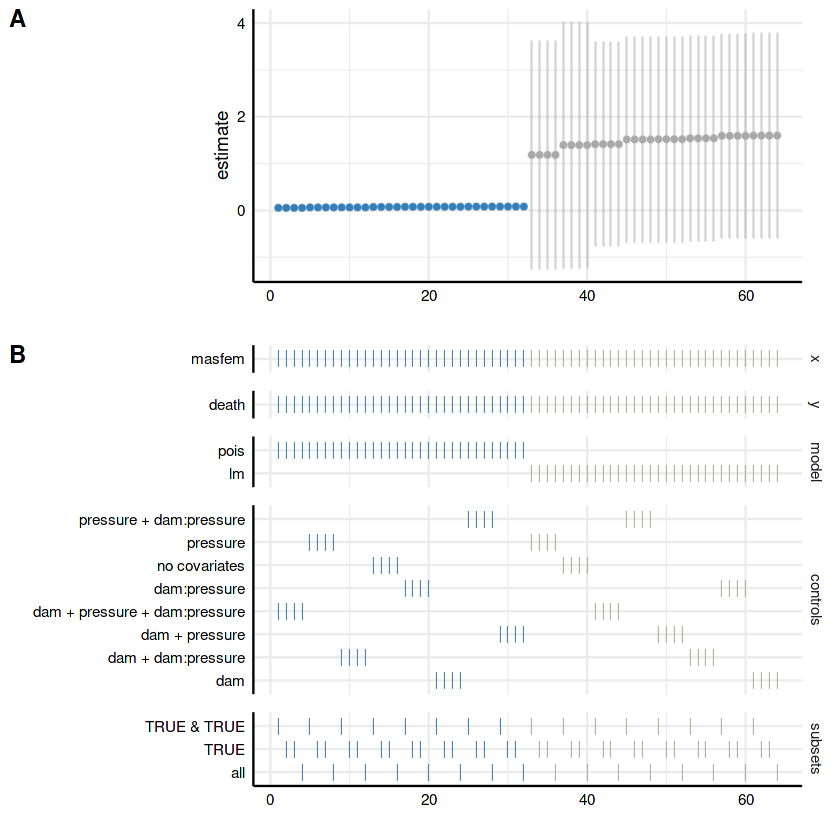

In [58]:
plot(results)

In [75]:
a <- pnorm(-2, mean = .25)
b <- pnorm(2, mean = .25, lower.tail = F)

X <- rnorm(n = 100000, mean = .25)
sig <- abs(X) > 2
mean(abs(X[sig] / .25))

[1] 9.543644